# Assignment 2: Multi-layer Feed Forward Neural Networks

Solutions to assignment #2 by K. Sai Somanath, 18MCMT28

## Question 1
## Extracting the images

In [1]:
# Necessary imports
import os
import struct
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from copy import deepcopy

In [2]:
# Some utility functions to read and extract data in desired format
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        print("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        _, __, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    get_img = lambda index: (lbl[index], img[index])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image.reshape(28, 28), cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [3]:
# Reading the images
TRAIN = read('training', 'MNIST'); TEST = read('testing', 'MNIST')

In [4]:
img_train = []; lbl_train = []
img_test = []; lbl_test = []

for temp in TRAIN:
    img_train.append(temp[1])
    lbl_train.append(temp[0])

for temp in TEST:
    img_test.append(temp[1])
    lbl_test.append(temp[0])

img_train = np.array(img_train); lbl_train = np.array(lbl_train)
img_test = np.array(img_test); lbl_test = np.array(lbl_test)

### The dataset
A look at a random image to make sure everything went well

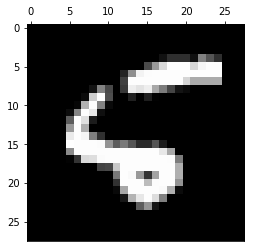

5


In [5]:
show(img_test[8])
print(lbl_test[8])

### One hot encoding the labels of the images

In [6]:
lbl_train = np.eye(10)[lbl_train]
lbl_test = np.eye(10)[lbl_test]

In [7]:
lbl_test.shape

(10000, 10)

Now the labels in the trainig smaplemhave been one hot encoded. Instaed of having a single digit representing the class name, we instead use a vector of size 10 to represent the class of the image

In [8]:
lbl_test[8]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

### Normalising the data

In [9]:
img_train = img_train / 255
img_test = img_test / 255

## The MLFFNN

In [10]:
class Relu:
    @staticmethod
    def activation(z):
        z[z < 0] = 0
        return z
    
    @staticmethod
    def derivative(z):
        z[z < 0] = 0
        z[z > 0] = 1
        return z
        
class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def derivative(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    
class MSE:
    def __init__(self, activation_fn=None):
        self.activation_fn = activation_fn
            
    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred)
    

class NeuralNetwork(object):
    def __init__(self, dimensions, activation_fns):
        self.dimensions = dimensions
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.weights = {}
        self.bais = {}
        self.activations = {}
        for i in range(self.n_layers - 1):
            self.weights[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.bais[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activation_fns[i]
    
    def __deepcopy__(self, memo):
        deepcopy_method = self.__deepcopy__
        self.__deepcopy__ = None
        cp = deepcopy(self, memo)
        self.__deepcopy__ = deepcopy_method
        # custom treatments
        cp.weights = {}; cp.bais = {}
        for i in range(cp.n_layers - 1):
            cp.weights[i + 1] = np.random.randn(cp.dimensions[i], cp.dimensions[i + 1]) / np.sqrt(cp.dimensions[i])
            cp.bais[i + 1] = np.zeros(cp.dimensions[i + 1])

        return cp
    
    def feed_forward(self, x):
        z = {}
        activated = {1: x}
        for i in range(1, self.n_layers):
            z[i + 1] = np.dot(activated[i], self.weights[i]) + self.bais[i]
            activated[i + 1] = self.activations[i + 1].activation(z[i + 1])
        return z, activated
    
    def back_propagation(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.n_layers])
        partial_derivative = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (partial_derivative, delta)
        }

        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.activations[i].derivative(z[i])
            partial_derivative = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (partial_derivative, delta)

        for key, values in update_params.items():
            self.update_fn(key, values[0], values[1])
        
    def update_fn(self, key, partial_derivative, delta):
        self.weights[key] -= self.learning_rate * partial_derivative
        self.bais[key] -= self.learning_rate * np.mean(delta, 0)

    def learn(self, x, y_true, loss, epochs, batch_size, learning_rate):
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        for i in range(epochs):
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_ = x[seed]
            y_ = y_true[seed]
            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_propagation(z, a, y_[k:l])
            _, _a = self.feed_forward(x)
            print("Epoch:", i + 1, "Loss:", self.loss.loss(y_true, _a[self.n_layers]), end='\r')
    
    def predict(self, x):
        _, a = self.feed_forward(x)
        return a[self.n_layers]


The above class allows us to create a network pf arbitary size and supports ReLU and Sigmoid as activations functions. 

Cross-validation is used to determine the better model for this problem, the value of k is 5, i.e. we create 5 splits of the data set. We then will use the results obtained model contructed in each fold to find the better one.

In [11]:
X = np.copy(img_train)
Y = np.copy(lbl_train)

# Creating the 5 fold cross-validation 
kf = KFold(n_splits=5)
"""
We create a new model in each fold and train on 4 splits while we hold the 5th split for testing. We repeat this 
process for all the combinations. We store the accuracy for each split and discard the model. The model with 
better accuracy will the better suited for our problem.
"""

# Define the models
"""This neural network has 3 layers, 784 input neurons, 100 in the hidden layer, and 10 in the output layer.
We use a learning rate of 0.01 and a modest 100 epochs to get a rough idea aboyt the model"""
nn1 = NeuralNetwork((784, 100, 10), (Relu, Sigmoid))

"""This neural network has 4 layers, 784 input neurons, 64, 64 in the hidden layers, and 10 in the output layer.
We use a learning rate of 0.1 and a modest 100 epochs to get a rough idea aboyt the model"""
nn2 = NeuralNetwork((784, 64, 64, 10), (Sigmoid, Sigmoid, Sigmoid))

## The error array is used to hold the errors made in each fold.
e1 = []; e2 = []

In [12]:
%%time
i = 1
for train, test in kf.split(X):
    x = X[train]; y = Y[train]
    x_ = X[test]; y_ = Y[test]
    print("Split: ", i)
    i += 1
    nn1.learn(x, y, MSE, 100, 128, 0.01)
    print()
    y_pred = np.argmax(nn1.predict(x_), axis=1)
    y_true = np.argmax(y_, axis=1)
    e1.append(accuracy_score(y_true, y_pred))

Split:  1
Epoch: 100 Loss: 1.4057382128508965e-05
Split:  2
Epoch: 100 Loss: 3.318764573361809e-06
Split:  3
Epoch: 100 Loss: 1.0544756549524098e-06
Split:  4
Epoch: 100 Loss: 4.900567055966747e-07
Split:  5
Epoch: 100 Loss: 2.904856635513469e-07
CPU times: user 1h 5min 58s, sys: 39min 11s, total: 1h 45min 10s
Wall time: 9min 37s


**The error rate of model 1:**

In [15]:
e1 = np.array(e1)
print("The mean error of the test-train split:", 1 - e1.mean())
print("The standard deviation of the test-train split", e1.std())

The mean error of the test-train split: 0.005483333333333507
The standard deviation of the test-train split 0.0081249615383705


In [16]:
%%time
i = 1
for train, test in kf.split(X):
    x = X[train]; y = Y[train]
    x_ = X[test]; y_ = Y[test]
    print("Split: ", i)
    i += 1
    nn2.learn(x, y, MSE, 100, 128, 0.01)
    print()
    y_pred = np.argmax(nn2.predict(x_), axis=1)
    y_true = np.argmax(y_, axis=1)
    e2.append(accuracy_score(y_true, y_pred))

Split:  1
Split:  20 Loss: 0.00023069723503835212
Split:  30 Loss: 2.6849426283975983e-05
Split:  40 Loss: 7.108218552595879e-06
Split:  50 Loss: 2.971821147846548e-06
CPU times: user 1h 9min 35s, sys: 1h 9min 26s, total: 2h 19min 1s
Wall time: 12min 26s


**The error rate of model 2:**

In [17]:
e2 = np.array(e2)
print("The mean error of the test-train split:", 1 - e2.mean())
print("The standard deviation of the test-train split", e2.std())

The mean error of the test-train split: 0.007016666666666671
The standard deviation of the test-train split 0.009158086893863566


In [18]:
e1 = np.array(e1); e2 = np.array(e2)
print("Avg. accuracy of Model 1:", e1.mean(), "\nAvg. accuracy of Model 2:", e2.mean())

Avg. accuracy of Model 1: 0.9945166666666665 
Avg. accuracy of Model 2: 0.9929833333333333


We can see that model one just, barely, performs better. We therefore choose, the first model to solve the problem.

## The Digit classifier
We have determined that the neural network #2 is the better one to perform classification. We will now train it to on the entire dataset.

We use each pixel as a feature to train the network. This results in a network that takes $28\times28$ number of pixels as input. We have two hidden layers each with 64 nuerons, activated by a Sigmoid function. Lastly, the output layer has 10 neuron which determine the class label of a given input image. 

In [19]:
%%time
# Choose the better model
if e1.mean() < e2.mean(): 
    nn_simple = deepcopy(nn1)
else:
    nn_simple = deepcopy(nn2)

# Train the network
nn_simple.learn(img_train, lbl_train, MSE, 500, 128, 0.01)

CPU times: user 1h 25min 32s, sys: 1h 20min 53s, total: 2h 46min 25s
Wall time: 15min


### Some metrics to guage the performance of the model

In [20]:
%%time
# Mak epredictions on the test set
y_pred = np.argmax(nn_simple.predict(img_test), axis=1)
# Get the true labels
y_true = np.argmax(lbl_test, axis=1)
print("Metrics of Performance")
print("Accuracy: ", accuracy_score(y_true, y_pred) * 100, "%")
print("-----------------------------------------------------")
print("\n\nConfusion Matrix\n")
print(confusion_matrix(y_pred, y_true))
print("-------------------------------------------------------")
print("\n\nOther metrics\n")
print(classification_report(y_pred, y_true))

Metrics of Performance
Accuracy:  97.67 %
-----------------------------------------------------


Confusion Matrix

[[ 967    0    2    0    0    4    6    2    4    4]
 [   0 1122    2    0    0    0    3    3    1    2]
 [   1    3 1009    5    3    0    3    9    2    0]
 [   1    3    6  990    1    7    1    4    6    1]
 [   0    0    3    0  957    1    4    0    3   12]
 [   4    1    0    5    0  868    2    0    6    6]
 [   2    2    2    0    4    2  938    0    1    0]
 [   1    1    4    5    1    1    0 1000    5    5]
 [   3    2    4    2    1    5    1    2  942    5]
 [   1    1    0    3   15    4    0    8    4  974]]
-------------------------------------------------------


Other metrics

             precision    recall  f1-score   support

          0       0.99      0.98      0.98       989
          1       0.99      0.99      0.99      1133
          2       0.98      0.97      0.98      1035
          3       0.98      0.97      0.98      1020
          4   

We have scored an accuracy of about 98%. From the precision column we note that all classes have high precision. This is also evident from the consfusion matrix. 

With more epochs, it seems like there is a good chance of overfitting the model.

## Question 2
Use KNN classifier to learn hand written digits

In [21]:
# Import the KNN from sklearn
from sklearn.neighbors import KNeighborsClassifier

# Perform 1 Nearest Neighbour
K = 1

### Change the input data format for 1-NN

In [22]:
y_train = np.argmax(lbl_train, axis=1)
y_test = np.argmax(lbl_test, axis=1)

### Training a 1NN model

In [23]:
clf_1nn = KNeighborsClassifier(K, algorithm='brute')
clf_1nn.fit(img_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [24]:
%%time
acc = clf_1nn.score(img_test, y_test)
print("Accuracy = ", (acc * 100))

Accuracy =  96.91
CPU times: user 3min 22s, sys: 3.5 s, total: 3min 26s
Wall time: 21.6 s


In [25]:
%%time
knn_pred = clf_1nn.predict(img_test)
print("Metrics of Performance")
print("Accuracy: ", accuracy_score(y_true, knn_pred) * 100, "%")
print("-----------------------------------------------------")
print("\n\nConfusion Matrix\n")
print(confusion_matrix(knn_pred, y_true))
print("-------------------------------------------------------")
print("\n\nOther metrics\n")
print(classification_report(knn_pred, y_true))

Metrics of Performance
Accuracy:  96.91 %
-----------------------------------------------------


Confusion Matrix

[[ 973    0    7    0    0    1    4    0    6    2]
 [   1 1129    6    1    7    1    2   14    1    5]
 [   1    3  992    2    0    0    0    6    3    1]
 [   0    0    5  970    0   12    0    2   14    6]
 [   0    1    1    1  944    2    3    4    5   10]
 [   1    1    0   19    0  860    5    0   13    5]
 [   3    1    2    0    3    5  944    0    3    1]
 [   1    0   16    7    5    1    0  992    4   11]
 [   0    0    3    7    1    6    0    0  920    1]
 [   0    0    0    3   22    4    0   10    5  967]]
-------------------------------------------------------


Other metrics

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       993
          1       0.99      0.97      0.98      1167
          2       0.96      0.98      0.97      1008
          3       0.96      0.96      0.96      1009
          4   

### Analysis and Oberservations

**Some general observations**
1. Accuracy: The 1NN classifier has obtained worse accuracy than that of the neural network
2. Training time: The nearest neighbour takes no time to train, as it is a lazy learner.


**Confusion matrix**

It looks like the neural network performs a tad bit better than the nearest neighbours. Both algorithms perform really well on **class 0** and **class 1**. The reason might be that, these are such numbers where one mostly can't go wrong when writing. The biggest hurdle for the nearest neighbour algorithm is that of **class 8**. 

It looks like it confused the number *8* with the number *5*, the most. When using a brute force algorithm such as euclidian distance, some *5* might seem like *8*. One such exmaple is an image displayed from the test set above.  

---

The nearest neighbour is associated with the dimensionality problem as it looks at all the features before determining the class of a point. It will have to look at 784 sized vector for 60,000 times and only then can it classify a point. 

The neural network on the other hand would have to do some matix multiplication, which depends on the number of hidden layers. The neural network has learnt some weights, unlike the nearest neighboiur algorithm, which simply stores all the training data and waits until the prediction time, to use them(training data) for classification.

We can clearly see this when we attempt to find the class labels of the test set. The neural network takes about 113ms, while the nearest neighbour takes about 22 seconds. (The processing time reported here are subject to change.)